# Price Prediciton Models Part 5: Classes again



## Classes

In [18]:
import torch, torchvision, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torchvision.transforms as transforms, torchvision.models as models
import matplotlib.pyplot as plt
import PIL, IPython
import pathlib
import pandas as pd
import math
import random
from tqdm.auto import tqdm
from collections import OrderedDict
#plt.style.use('dark_background')
import numpy as np
import scipy
from scipy import stats
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda')

In [48]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [32]:
labels = pd.read_csv(dataset_dir + 'all_labels.csv')

### Some Data Visualization

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 7 Text major ticklabel objects>)

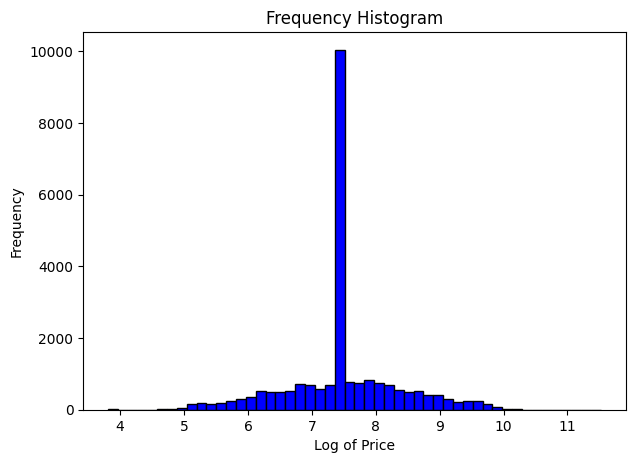

In [28]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
p = labels.apply(lambda row: math.log(row['price']), axis=1)
plt.hist(p, bins=50, color='b', lw=1, ec='k')
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', facecolor='w')
plt.ylabel('Frequency', color='k')
plt.xlabel('Log of Price', color='k')
plt.xticks(color='k')
plt.yticks(color='k')



In [6]:
p

0        9.729134
1        9.035987
2        9.546813
3        8.853665
4        8.160518
           ...   
24502    7.444249
24503    7.444249
24504    7.444249
24505    7.444249
24506    7.444249
Length: 24507, dtype: float64

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 7 Text major ticklabel objects>)

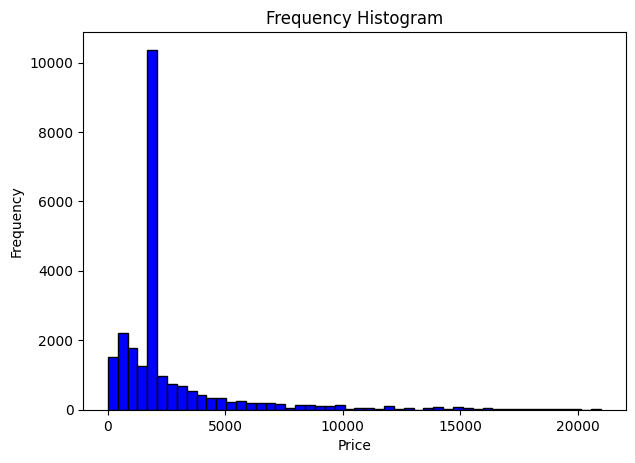

In [29]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
p1 = labels['price']
plt.hist(p1, bins=50, color='b', lw=1, ec='k', range=[0, 21000])
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', facecolor='w')
plt.ylabel('Frequency', color='k')
plt.xlabel('Price', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


In [16]:
scipy.stats.mode(p1)

ModeResult(mode=array([1710.]), count=array([9332]))

In [22]:
len(p1)

24507

In [46]:
random.random()

0.15201380350000082

## Down sample

In [47]:
#all_labels = pd.read_csv('/content/drive/My Drive/CPEN 291/project/data/all_labels.csv', index_col=0)
#all_labels = all_labels.dropna()
dropping = []
for index, i in labels.iterrows():
  if (not os.path.exists('/content/drive/My Drive/CPEN 291/project/data/' + i['name'])):
    dropping.append(index)
  elif (math.isnan(i['price'])):
    dropping.append(index)
  elif (i['price'] == 1710 and random.random() > 0.05): # randomly drop about 95% of data of price 1710
    dropping.append(index)

labels = labels.drop(dropping)

input()
labels.to_csv('/content/drive/My Drive/CPEN 291/project/data_classes/all_labels.csv')


ok


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 <a list of 8 Text major ticklabel objects>)

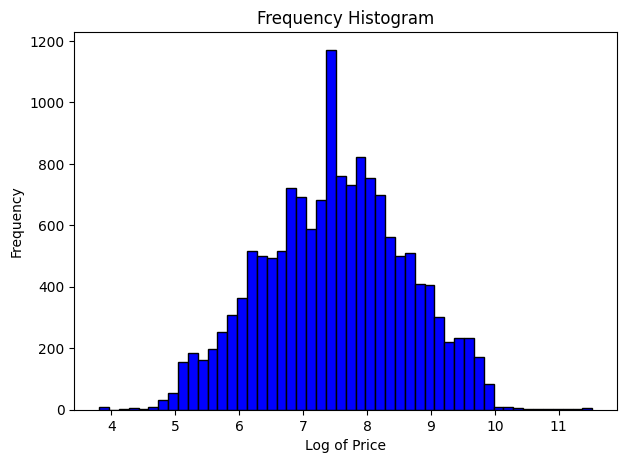

In [49]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
p = labels.apply(lambda row: math.log(row['price']), axis=1)
plt.hist(p, bins=50, color='b', lw=1, ec='k')
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', facecolor='w')
plt.ylabel('Frequency', color='k')
plt.xlabel('Log of Price', color='k')
plt.xticks(color='k')
plt.yticks(color='k')



(array([   0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 6 Text major ticklabel objects>)

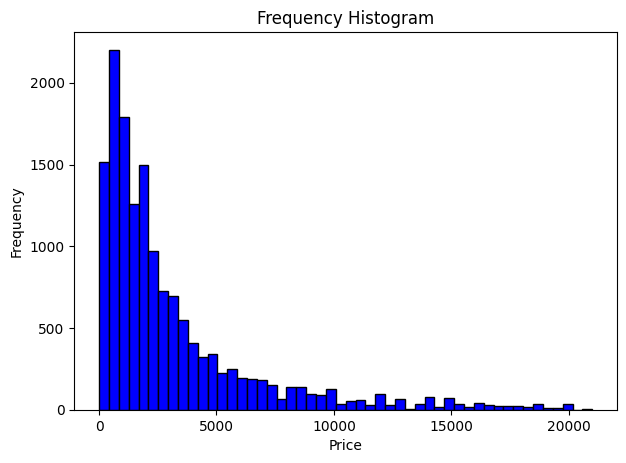

In [50]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
p1 = labels['price']
plt.hist(p1, bins=50, color='b', lw=1, ec='k', range=[0, 21000])
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', facecolor='w')
plt.ylabel('Frequency', color='k')
plt.xlabel('Price', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


In [51]:
len(p1)

15055

### Making Classes

We would want to have many classes, to simulate having continuous output values.  
And we would want our data to be evenly distributed in those classes.

In [52]:
classes = pd.DataFrame(columns=['price', 'index'])
sorted = labels.sort_values(by=['price'])
sorted = sorted.reset_index()
sorted = sorted.dropna()
print(sorted.head())
last_one = 0
add_amt = 35
for i in range(0, 50):
  index = math.floor(i/50.0 * sorted['price'].size)
  class_ = sorted['price'][index]
  # This step prevents the difference of two classes from being too small
  # + 35 seems to yield the lowest SD (see classes bar graph below)
  while (class_ <= last_one + add_amt): 
    index += 1
    class_ = sorted['price'][index]

  last_one = class_
  classes = classes.append({'price' : class_, 'index': index}, ignore_index=True)

print(classes)




   index  Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1            name  price
0   3715        3715          3715            3715  artsy_2755.jpg   45.0
1   3335        3335          3335            3335  artsy_2366.jpg   45.0
2   3338        3338          3338            3338  artsy_2369.jpg   45.0
3   3861        3861          3861            3861  artsy_2903.jpg   45.0
4   3476        3476          3476            3476  artsy_2510.jpg   45.0
      price    index
0      45.0      0.0
1     189.0    301.0
2     240.0    602.0
3     300.0    903.0
4     355.0   1204.0
5     415.0   1505.0
6     470.0   1806.0
7     510.0   2143.0
8     560.0   2408.0
9     610.0   2709.0
10    680.0   3011.0
11    744.0   3312.0
12    800.0   3613.0
13    880.0   3914.0
14    940.0   4215.0
15    990.0   4516.0
16   1049.0   4817.0
17   1135.0   5118.0
18   1210.0   5419.0
19   1310.0   5720.0
20   1410.0   6022.0
21   1510.0   6323.0
22   1610.0   6624.0
23   1710.0   6925.0
24   1750.0   7350.0
25   1800.

#### Price distribution
As shown below, our data can be more or less evenly distributed in our classes. This helps training more effectively and our classes can represent the distribution of prices in real life.

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000., 18000.]), <a list of 11 Text major ticklabel objects>)

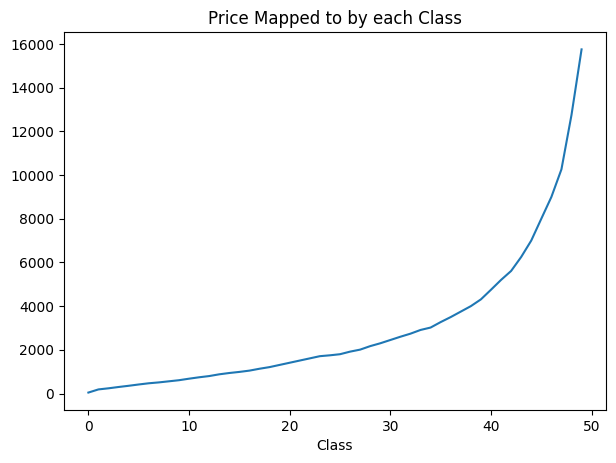

In [53]:
classes['price'].plot()
plt.gca().set( title='Price Mapped to by each Class', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')
#plt.xlim([0, 20000])

(0.0, 21000.0)

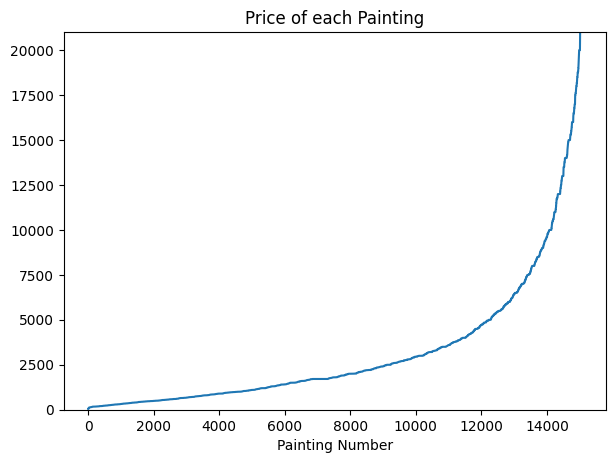

In [55]:
sorted['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price of each Painting', facecolor='w')
plt.xlabel('Painting Number', color='k')
plt.xticks(color='k')
plt.yticks(color='k')
plt.ylim([0, 21000])


In [56]:
print(classes['price'][0])
print(classes['price'][49])

45.0
15750.0


In [57]:
# Analyze the distribution of our data in these classes
classes_hist = np.zeros(50)
indices = np.zeros(50)
for i in range(1, 50):
  indices[i] = indices[i - 1] + 1

for p in labels['price']:
  for i in range(0, 49):
    if (p >= classes['price'][i] and p < classes['price'][i + 1]): 
      classes_hist[i] += 1
  if (p >= classes['price'][49]):
    classes_hist[49] += 1

print(classes_hist)
print(classes_hist.sum())
print(sorted['price'].size)
print(f"""
Average: {np.average(classes_hist)}
Variance: {np.var(classes_hist)}
SD: {np.std(classes_hist)}
Median: {np.median(classes_hist)}
Max: {np.max(classes_hist)}
Min: {np.min(classes_hist)}
""")



[301. 284. 305. 309. 299. 307. 338. 252. 297. 315. 305. 227. 360. 280.
 309. 329. 300. 296. 279. 295. 331. 283. 244. 505. 114. 363. 292. 291.
 318. 305. 290. 307. 303. 301. 292. 279. 324. 296. 317. 273. 317. 314.
 300. 283. 319. 301. 302. 293. 308. 303.]
15055.0
15055

Average: 301.1
Variance: 2081.97
SD: 45.62860944626737
Median: 301.0
Max: 505.0
Min: 114.0



In [58]:
classes['price'][15]

990.0

[Text(0.5, 1.0, 'Distribution of data in classes')]

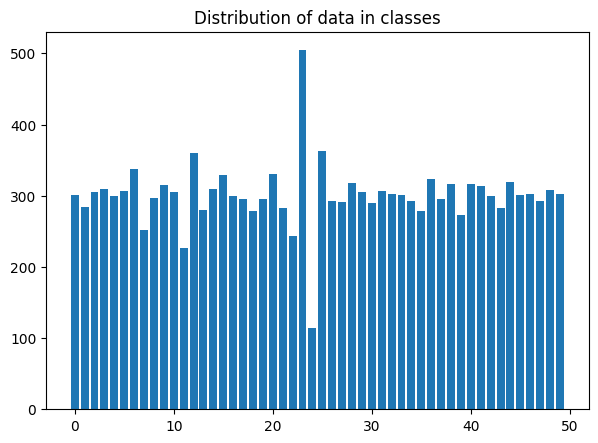

In [60]:
plt.bar(indices,classes_hist)
plt.gca().set( title='Distribution of data in classes')

In [61]:
# Some more manual intervention to even out the distribution
classes_2 = classes.copy()
for i in range (0, 48):
  if (classes_hist[i] * 1.3 < classes_hist[i+1]):
    classes_2['index'][i+1] = math.floor(classes['index'][i+1] + (classes['index'][i+2] - classes['index'][i+1]) * 1/5)
    classes_2['price'][i+1] = sorted['price'][classes_2['index'][i+1]]


classes_hist_2 = np.zeros(50)

for p in labels['price']:
  for i in range(0, 49):
    if (p >= classes_2['price'][i] and p < classes_2['price'][i + 1]): 
      classes_hist_2[i] += 1
  if (p >= classes_2['price'][49]):
    classes_hist_2[49] += 1

print(classes_hist_2)
print(classes_hist_2.sum())
print(sorted['price'].size)
print(f"""
Average: {np.average(classes_hist_2)}
Variance: {np.var(classes_hist_2)}
SD: {np.std(classes_hist_2)}
Median: {np.median(classes_hist_2)}
Max: {np.max(classes_hist_2)}
Min: {np.min(classes_hist_2)}
""")


[301. 284. 305. 309. 299. 307. 338. 252. 297. 315. 305. 356. 231. 280.
 309. 329. 300. 296. 279. 295. 331. 283. 244. 505. 223. 254. 292. 291.
 318. 305. 290. 307. 303. 301. 292. 279. 324. 296. 317. 273. 317. 314.
 300. 283. 319. 301. 302. 293. 308. 303.]
15055.0
15055

Average: 301.1
Variance: 1450.93
SD: 38.09107507015259
Median: 301.0
Max: 505.0
Min: 223.0



##### Some statistics about the distribution of data in our classes
| | | 
|--- | --- | 
Total number of paintings |  15055  
Average| 301.1  
Variance| 1450.93
SD| 38.0910  
Median| 301.0  
Max| 505.0  
Min| 223.0  

[Text(0.5, 1.0, 'Distribution of data in classes (2)')]

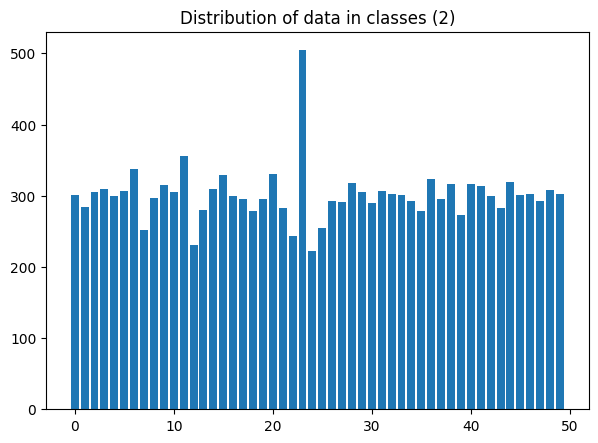

In [63]:
plt.bar(indices,classes_hist_2)
plt.gca().set( title='Distribution of data in classes (2)')


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000., 18000.]), <a list of 11 Text major ticklabel objects>)

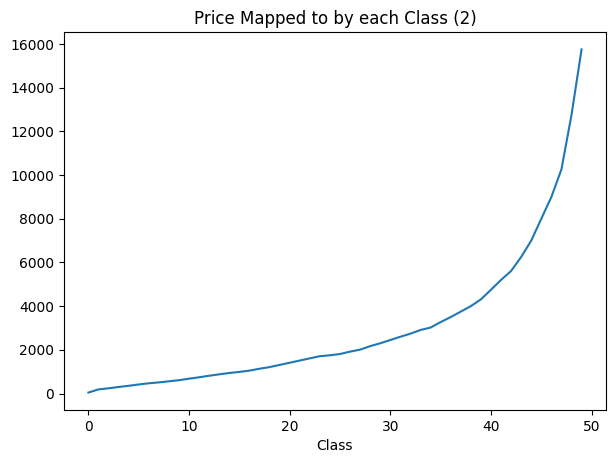

In [64]:
classes_2['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price Mapped to by each Class (2)', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')
#plt.xlim([0, 20000])

In [65]:
classes_2.to_csv('/content/drive/My Drive/CPEN 291/project/data_classes/classes_50.csv')

### Making different numbers of classes

In [42]:
# Function to help make classes
def make_classes(labels, number):
  _classes = pd.DataFrame(columns=['price', 'index'])
  _sorted = labels.sort_values(by=['price'])
  _sorted = _sorted.reset_index()
  _last_one = 0
  _add_amt = 35
  if (number > 100):
    _add_amt = 10
  for i in range(0, number):
    _index = math.floor(float(i)/number * _sorted['price'].size)
    _class_ = _sorted['price'][_index]
    # This step prevents the difference of two classes from being too small
    # + 35 seems to yield the lowest SD (see classes bar graph below)
    while (_class_ <= _last_one + _add_amt): 
      _index += 1
      _class_ = _sorted['price'][_index]
    _last_one = _class_
    _classes = _classes.append({'price' : _class_, 'index': _index}, ignore_index=True)

  _classes_hist = np.zeros(number)
  _indices = np.zeros(number)
  for i in range(1, number):
    _indices[i] = _indices[i - 1] + 1
  
  for p in labels['price']:
    for i in range(0, number-1):
      if (p >= _classes['price'][i] and p < _classes['price'][i + 1]): 
        _classes_hist[i] += 1
        break
    if (p >= _classes['price'][number-1]):
      _classes_hist[number-1] += 1
      
  _classes_2 = _classes.copy()
  for i in range (0, number-2):
    if (_classes_hist[i] * 1.3 < _classes_hist[i+1]):
      _classes_2['index'][i+1] = math.floor(_classes['index'][i+1] + (_classes['index'][i+2] - _classes['index'][i+1]) * 1/5)
      _classes_2['price'][i+1] = _sorted['price'][_classes_2['index'][i+1]]

  return _classes_2


In [41]:
def analyze_classes(labels, classes, number):
  _ch = np.zeros(number)
  _indices = np.zeros(number)
  for i in range(1, number):
    _indices[i] = _indices[i - 1] + 1
  
  for p in labels['price']:
    for i in range(0, number-1):
      if (p >= classes['price'][i] and p < classes['price'][i + 1]): 
        _ch[i] += 1
        break
    if (p >= classes['price'][number-1]):
      _ch[number-1] += 1
  
  
  print(_ch)
  print(_ch.sum())
  print(f"""
  Average: {np.average(_ch)}
  Variance: {np.var(_ch)}
  SD: {np.std(_ch)}
  Median: {np.median(_ch)}
  Max: {np.max(_ch)}
  Min: {np.min(_ch)}
  """)
  plt.bar(_indices,_ch, width=7)
  plt.gca().set( title='Distribution of data in '+ str(number) + ' classes ')


In [68]:
classes_100 = make_classes(labels=labels, number=100)

In [ ]:
print(classes_100)

In [69]:
classes_100.to_csv('/content/drive/My Drive/CPEN 291/project/data_classes/classes_100.csv')


[200. 228. 177. 199. 192. 203. 172. 163. 271. 326. 149. 202. 263. 156.
 186. 160. 175. 117. 175. 180. 220. 130. 219. 237. 143. 125. 141. 149.
 154.  69. 114. 138. 107.  42. 191.  86. 159.  77.  81. 170. 106.  93.
 496. 123. 143.  50.  65. 126. 103. 227.  35.  53. 112.  73. 172.  33.
  64.  76. 114. 123.  80. 210. 161. 146. 169. 134. 153. 159. 140. 141.
 162. 117. 185. 139. 162. 134. 167. 150. 151. 122. 148. 169. 145. 169.
 150. 150. 140. 143. 159. 160. 146. 155. 135. 167. 150. 143. 159. 149.
 141. 162.]
15055.0

  Average: 150.55
  Variance: 3652.0075000000006
  SD: 60.43184177236369
  Median: 149.5
  Max: 496.0
  Min: 33.0
  


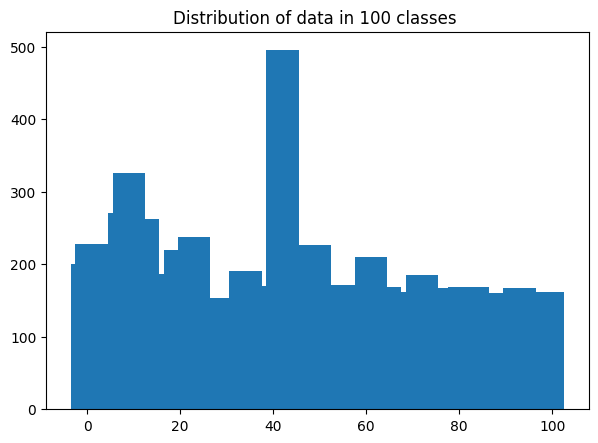

In [70]:
analyze_classes(labels=labels, classes=classes_100, number=100)

(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000.]), <a list of 10 Text major ticklabel objects>)

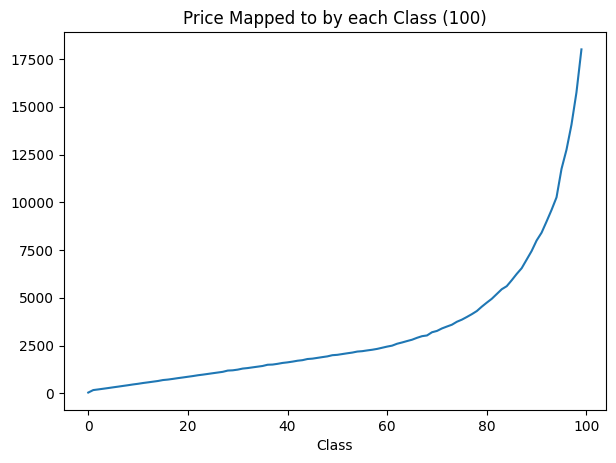

In [71]:
classes_100['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price Mapped to by each Class (100)', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


In [72]:
classes_30 = make_classes(labels=labels, number=30)

In [73]:
print(classes_30)

      price    index
0      45.0      0.0
1     225.0    501.0
2     320.0   1003.0
3     415.0   1505.0
4     490.0   2007.0
5     580.0   2509.0
6     680.0   3011.0
7     790.0   3512.0
8     900.0   4014.0
9     990.0   4516.0
10   1100.0   5018.0
11   1260.0   5520.0
12   1410.0   6022.0
13   1600.0   6523.0
14   1710.0   7125.0
15   1800.0   7527.0
16   2000.0   8029.0
17   2200.0   8531.0
18   2450.0   9033.0
19   2690.0   9534.0
20   2960.0  10036.0
21   3270.0  10538.0
22   3610.0  11040.0
23   4050.0  11542.0
24   4750.0  12044.0
25   5500.0  12545.0
26   6500.0  13047.0
27   8000.0  13549.0
28   9895.0  14051.0
29  14000.0  14553.0


In [74]:
classes_30.to_csv('/content/drive/My Drive/CPEN 291/project/data_classes/classes_30.csv')


[495. 502. 501. 483. 508. 518. 487. 488. 506. 497. 523. 479. 524. 334.
 619. 487. 536. 546. 491. 509. 493. 500. 508. 481. 508. 500. 525. 500.
 502. 505.]
15055.0

  Average: 501.8333333333333
  Variance: 1638.738888888889
  SD: 40.481340008563066
  Median: 501.5
  Max: 619.0
  Min: 334.0
  


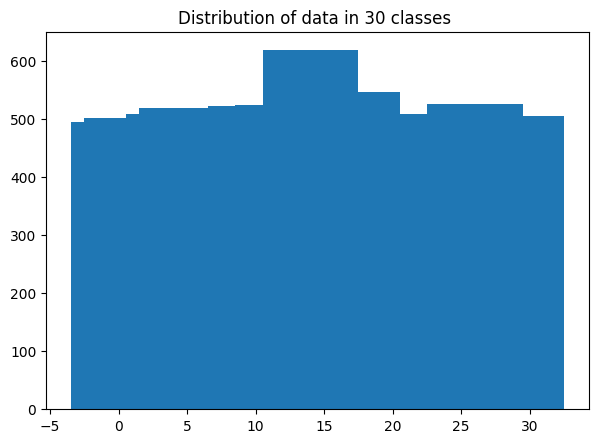

In [75]:
analyze_classes(labels=labels, classes=classes_30, number=30)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000.]), <a list of 10 Text major ticklabel objects>)

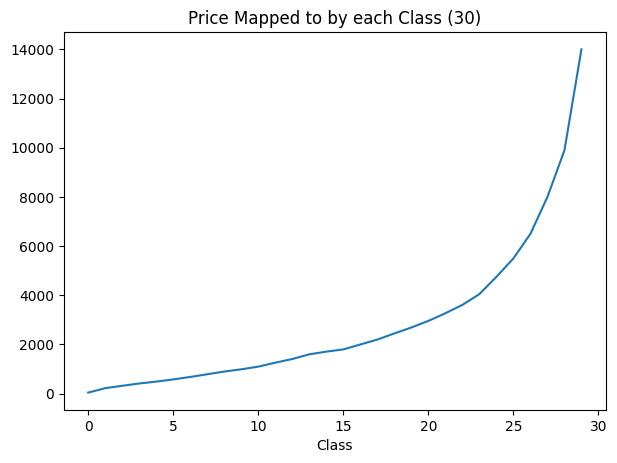

In [76]:
classes_30['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price Mapped to by each Class (30)', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


In [77]:
classes_20 = make_classes(labels=labels, number=20)

In [78]:
print(classes_20)

      price    index
0      45.0      0.0
1     270.0    752.0
2     415.0   1505.0
3     540.0   2258.0
4     680.0   3011.0
5     845.0   3763.0
6     990.0   4516.0
7    1195.0   5269.0
8    1410.0   6022.0
9    1680.0   6774.0
10   1800.0   7527.0
11   2100.0   8280.0
12   2450.0   9033.0
13   2800.0   9785.0
14   3270.0  10538.0
15   3860.0  11291.0
16   4750.0  12044.0
17   5920.0  12796.0
18   8000.0  13549.0
19  11746.0  14302.0


In [79]:
classes_20.to_csv('/content/drive/My Drive/CPEN 291/project/data_classes/classes_20.csv')


[719. 779. 760. 749. 755. 726. 770. 729. 780. 697. 802. 767. 716. 777.
 765. 724. 781. 752. 753. 754.]
15055.0

  Average: 752.75
  Variance: 683.5875
  SD: 26.14550630605573
  Median: 754.5
  Max: 802.0
  Min: 697.0
  


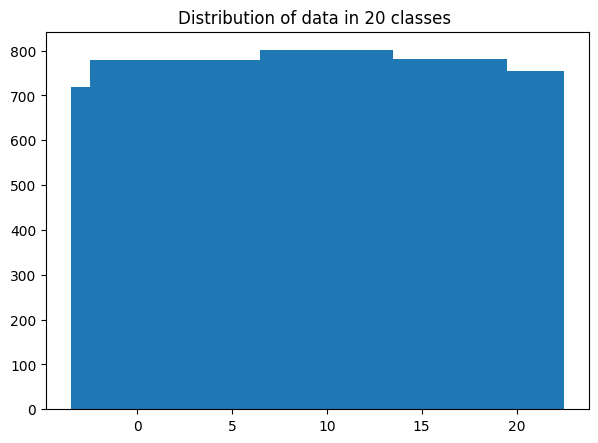

In [80]:
analyze_classes(labels=labels, classes=classes_20, number=20)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000.]), <a list of 9 Text major ticklabel objects>)

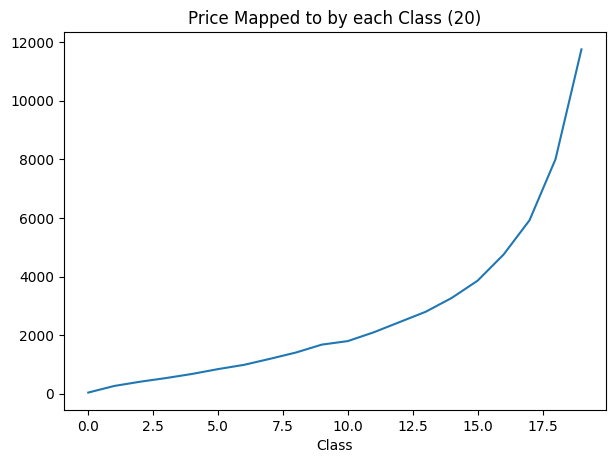

In [81]:
classes_20['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price Mapped to by each Class (20)', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


In [43]:
classes_10 = make_classes(labels=labels, number=10)

In [44]:
print(classes_10)

    price    index
0    45.0      0.0
1   415.0   1505.0
2   680.0   3011.0
3   990.0   4516.0
4  1410.0   6022.0
5  1800.0   7527.0
6  2450.0   9033.0
7  3270.0  10538.0
8  4750.0  12044.0
9  8000.0  13549.0


In [45]:
classes_10.to_csv('/content/drive/My Drive/CPEN 291/project/data_classes/classes_10.csv')


[1498. 1509. 1481. 1499. 1477. 1569. 1493. 1489. 1533. 1507.]
15055.0

  Average: 1505.5
  Variance: 674.25
  SD: 25.96632434519757
  Median: 1498.5
  Max: 1569.0
  Min: 1477.0
  


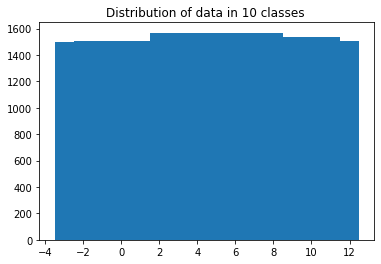

In [46]:
analyze_classes(labels=labels, classes=classes_10, number=10)

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.,  9000.]), <a list of 11 Text major ticklabel objects>)

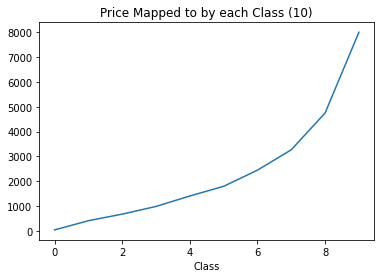

In [48]:
classes_10['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price Mapped to by each Class (10)', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


## Model

In [1]:
import torch, torchvision, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torchvision.transforms as transforms, torchvision.models as models
import matplotlib.pyplot as plt
import PIL, IPython
import pathlib
import pandas as pd
import math
import random
from tqdm.auto import tqdm
from collections import OrderedDict
#plt.style.use('dark_background')
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda')

In [4]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [5]:
label_dir = '/content/drive/My Drive/CPEN 291/project/data_classes/'

In [49]:
classes = pd.read_csv(label_dir + 'classes_10.csv')
 

In [7]:
labels = pd.read_csv(label_dir + 'all_labels.csv')

In [52]:
class PriceClassificationDataset:
    def __init__(self, root_dir, label_dir, transform=None, transform_label=None):

        root_dir = pathlib.Path(root_dir).resolve()
        label_dir = pathlib.Path(label_dir).resolve()
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.transform = transform
        self.transform_label = transform_label

        self.classes = pd.read_csv(label_dir / 'classes_10.csv')

        self.labels_f = pd.read_csv(label_dir / 'all_labels.csv')

        self.img_names = self.labels_f['name']

        def get_class(p):
          if (p >= classes['price'][9]):
              return 9
          for i in range(0, len(classes['price'])-1):
            if (p >= self.classes['price'][i] and p < self.classes['price'][i + 1]): 
              return i

        def get_price(fn):
            fn = str(fn)
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return row['price'][index]

        self.fns_labels = [(imgfn, get_class(get_price(imgfn)))
                           for imgfn in self.img_names]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(self.root_dir / imgfn)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [10]:
# Modified from object_detection.ipynb
def show_img_price(sample):
    img, class_ = sample
    price = classes['price'][class_]
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(price, color='black') # add color='w' arg if using a dark background
    plt.axis('off')

In [53]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
dataset_full = PriceClassificationDataset(dataset_dir, label_dir=label_dir, transform=xform)
len(dataset_full)

15055

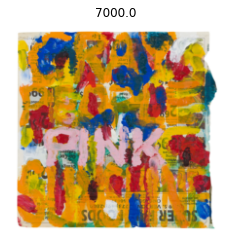

In [22]:
show_img_price(dataset_full[10])

In [54]:
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(291)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)
len(dataset_train), len(dataset_test)

(12044, 3011)

In [55]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

In [35]:
def run_test(model, criterion, no_mispreds=False):
    nsamples_test = len(dataset_test)
    loss, correct = 0, 0
    model.eval()
    mispreds = []
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device)
            outs = model(samples)
            loss += criterion(outs, labels)
            _, preds = torch.max(outs.detach(), 1) # pick highest-score class
            correct += (preds == labels).sum(0).item()
            if not no_mispreds:
                mispreds += [(s, p, l) for s, p, l in zip(samples.unbind(), preds, labels) if p != l]
    return loss / nsamples_test, correct / nsamples_test, mispreds

def run_train(model, criterion, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar, correct_sofar = 0, 0
    model.train()
    with torch.enable_grad():
        # tqdm = pretty progress bar
        for samples, labels in tqdm(loader_train, desc='iters', leave=False):
            samples = samples.to(device)
            labels = labels.to(device)
            opt.zero_grad()
            outs = model(samples)
            _, preds = torch.max(outs.detach(), 1) # pick highest-score class
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            correct_sofar += torch.sum(preds == labels.detach())
    sched.step()
    return loss_sofar / nsamples_train, correct_sofar / nsamples_train

def run_all(model, criterion, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train, acc_train = run_train(model, criterion, optimizer, scheduler)
        loss_test, acc_test, _ = run_test(model, criterion, no_mispreds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")
    return loss_test, acc_test

In [85]:
model = torchvision.models.resnet34(pretrained=True)

trim = False
# from https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
if (trim):
  model.layer3 = Identity();
  model.layer4 = Identity();

#model.fc = torch.nn.Linear(model.fc.in_features, len(dataset_full.classes))
model.fc = torch.nn.Linear(model.fc.in_features, 50)
#model.fc = torch.nn.Linear(128, len(dataset_full.classes))
torch.nn.init.xavier_uniform_(model.fc.weight)

model.to(device);

In [60]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [ ]:
loss_test, acc_test, _ = run_test(model, criterion, no_mispreds=True)
loss_test, acc_test

In [61]:
run_all(model, criterion, optimizer, scheduler, 10)

epoch 1: train loss 2.3650 acc 0.1425, test loss 0.0701 acc 0.1558


epoch 2: train loss 2.0793 acc 0.2909, test loss 0.0691 acc 0.1817


epoch 3: train loss 2.0332 acc 0.3220, test loss 0.0689 acc 0.1840


epoch 4: train loss 2.0262 acc 0.3275, test loss 0.0691 acc 0.1780


epoch 5: train loss 2.0263 acc 0.3248, test loss 0.0691 acc 0.1827


epoch 6: train loss 2.0256 acc 0.3240, test loss 0.0690 acc 0.1850


epoch 7: train loss 2.0259 acc 0.3251, test loss 0.0690 acc 0.1827


epoch 8: train loss 2.0272 acc 0.3226, test loss 0.0689 acc 0.1850


epoch 9: train loss 2.0250 acc 0.3286, test loss 0.0689 acc 0.1823


epoch 10: train loss 2.0260 acc 0.3287, test loss 0.0691 acc 0.1813



(tensor(0.0691, device='cuda:0'), 0.1813351046164065)

model | no. of classes |epochs| crit | optim | sched | train loss | train acc | test loss | test acc | MESLoss (see below) | saved
--- | --- | --- | --- |--- |--- |--- | --- | ---| ---|---| ---
resnet34, fc=1 linear | 50 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.8920| 0.0510| 0.1228| 0.0538| 3.0114| yes
resnet34, fc=1 linear | 20 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 2.9547| 0.1028| 0.0932| 0.0907| 2.7844| yes
resnet34, fc=1 linear | 10 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=1, g=0.1| 2.0260| 0.3287| 0.0691| 0.1813| 2.0410| yes


In [62]:
torch.save(model.state_dict(), '/content/drive/My Drive/CPEN 291/project/sd/model_5_10.pth')
torch.save(optimizer.state_dict(), '/content/drive/My Drive/CPEN 291/project/sd/optim_5_10.pth')
torch.save(scheduler.state_dict(), '/content/drive/My Drive/CPEN 291/project/sd/sched_5_10.pth')

In [ ]:
test_loss, test_preds, mis_preds = run_test(model, criterion)
print(test_loss)

tensor(0.1300, device='cuda:0')


In [ ]:
test_preds

0.08666666666666667

In [ ]:
mis_preds

## How does it stack up against the other models?

The accuracy is far from good... But where does it stand among all models?

As shown below, the test loss is quite a bit better than training a model that outputs continuous values. 

In [86]:
model.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/sd/model_5_50.pth'))
classes = pd.read_csv(label_dir + 'classes_50.csv')

In [80]:
# wrapper class for comparison
# untrainable, only for demo
class wrapper(nn.Module):
    def __init__(self):
        super(wrapper, self).__init__()
        self.model = model

    def forward(self, x):
        x = self.model(x)
        _, pred = torch.max(x.detach(), 1) # pick highest-score class
        for i in range(pred.size()[0]):
          if (pred[i].item() < 19):
            pred[i] = math.log(classes['price'][pred[i].item()] + (classes['price'][pred[i].item()+1] - classes['price'][pred[i].item()]) * (1/random.uniform(1.2, 3)))
          else:
            pred[i] = math.log(classes['price'][pred[i].item()] + (20000 - classes['price'][pred[i].item()]) * (1/random.uniform(1.2, 3)))
        return pred.unsqueeze(1)

def run_test_2(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test2)
    loss = 0
    preds = []
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test2:
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outs = model(samples)
            if not no_preds:
                preds += outs.cpu().unbind()
            loss += criterion(outs, labels) * samples.size(0)
    return loss / nsamples_test, preds

In [64]:
# Modified from object_detection.ipynb
class PricePredictionDataset:
    def __init__(self, root_dir, use_random=False, transform=None, transform_label=None):
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        if (use_random):
          self.labels_f = pd.read_csv(root_dir / 'all_labels_random.csv')
        else:
          self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')

        def get_price(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return math.log(row['price'][index]) # log because we are scientists

        self.fns_labels = [(imgfn, get_price(imgfn))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(imgfn)
        if (len(img.split()) > 3): # some images have one more channel
          r,g,b, _ = img.split()
          img = PIL.Image.merge('RGB', (r,g,b))
        if (len(img.split()) == 1): # some images only have one channel
          img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [65]:
dataset_full2= PricePredictionDataset(dataset_dir, False, transform=xform)

In [66]:
n_all= len(dataset_full2)
n_used= int(1 * n_all)
n_train= int(0.8 * n_used)
n_test= n_used- n_train
rng= torch.Generator().manual_seed(1910)
dataset_train2, dataset_test2, _ = torch.utils.data.random_split(dataset_full2, [n_train, n_test, n_all-n_train-n_test], rng)
len(dataset_train2), len(dataset_test2)

(19116, 4780)

In [67]:
loader_train2 = torch.utils.data.DataLoader(dataset_train2, batch_size=32, shuffle=False)
loader_test2 = torch.utils.data.DataLoader(dataset_test2, batch_size=32, shuffle=False)

In [68]:
criterion2 = torch.nn.MSELoss()

In [87]:
w = wrapper()
test_loss, test_preds= run_test_2(w, criterion2)
print(test_loss)

tensor(3.0114, device='cuda:0')


In [ ]:
test_loss

tensor(1.0029, device='cuda:0')

In [70]:
# Modified from object_detection.ipynb
def show_img_price2(sample):
    img, price = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(math.e**price, color='black') # add color='w' arg if using a dark background
    plt.axis('off')

Prediction     | Real Price


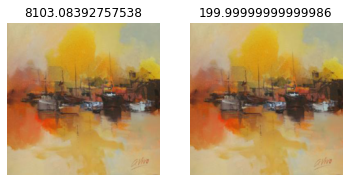

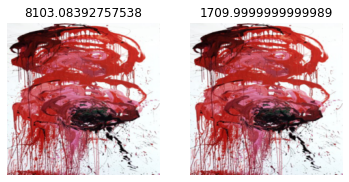

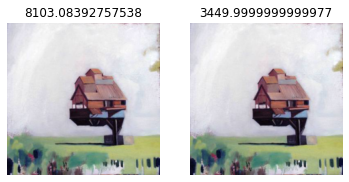

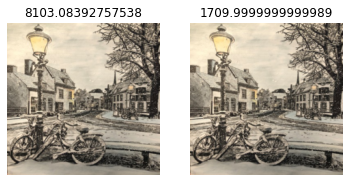

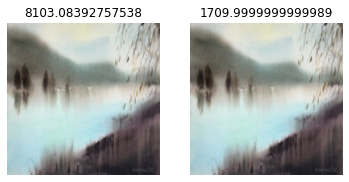

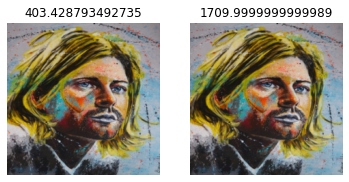

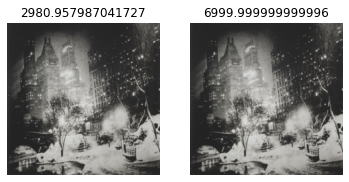

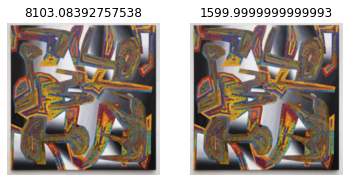

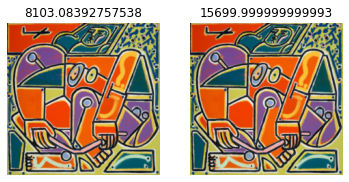

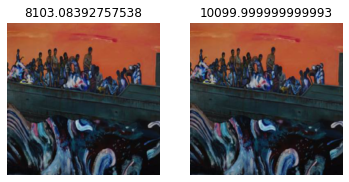

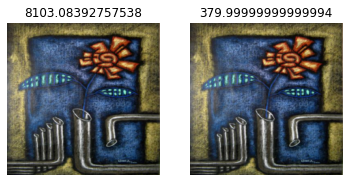

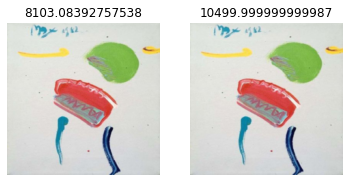

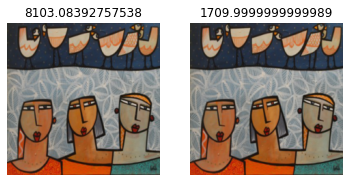

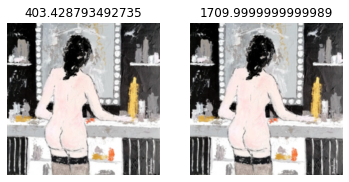

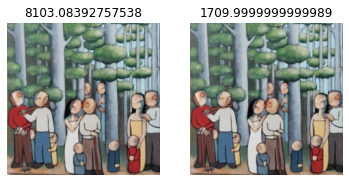

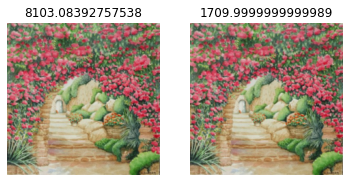

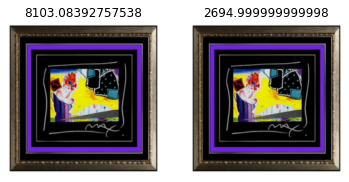

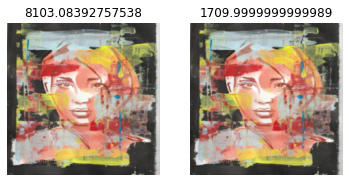

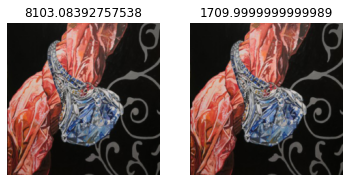

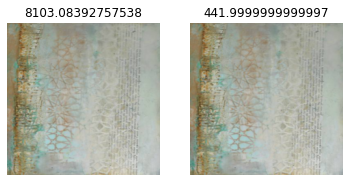

In [88]:
print("Prediction     | Real Price")
for i in range(20):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    show_img_price2((dataset_test2[i][0], test_preds[i].item()))
    f.add_subplot(1,2, 2)
    show_img_price2(dataset_test2[i])
    plt.show(block=True)
